In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import argparse
import os
import itertools as it
import math
import shapely

In [2]:
path1 = 'C:/Users/User/Desktop/barcode_proj/images/easier/plate1.jpg'

image_coloured = cv2.imread(path1)
image = cv2.cvtColor(image_coloured, cv2.COLOR_BGR2GRAY)
image_h, image_w =image.shape
print(image.shape)

(2173, 1892)


In [3]:
#median blur helps to eliminate salt&pepper noise - if it lowers DataMatrix decoding accuracy, it can be changed or eliminated.
blurred = cv2.medianBlur(image,3)


adapt_mean = cv2.adaptiveThreshold(blurred,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,35,2)


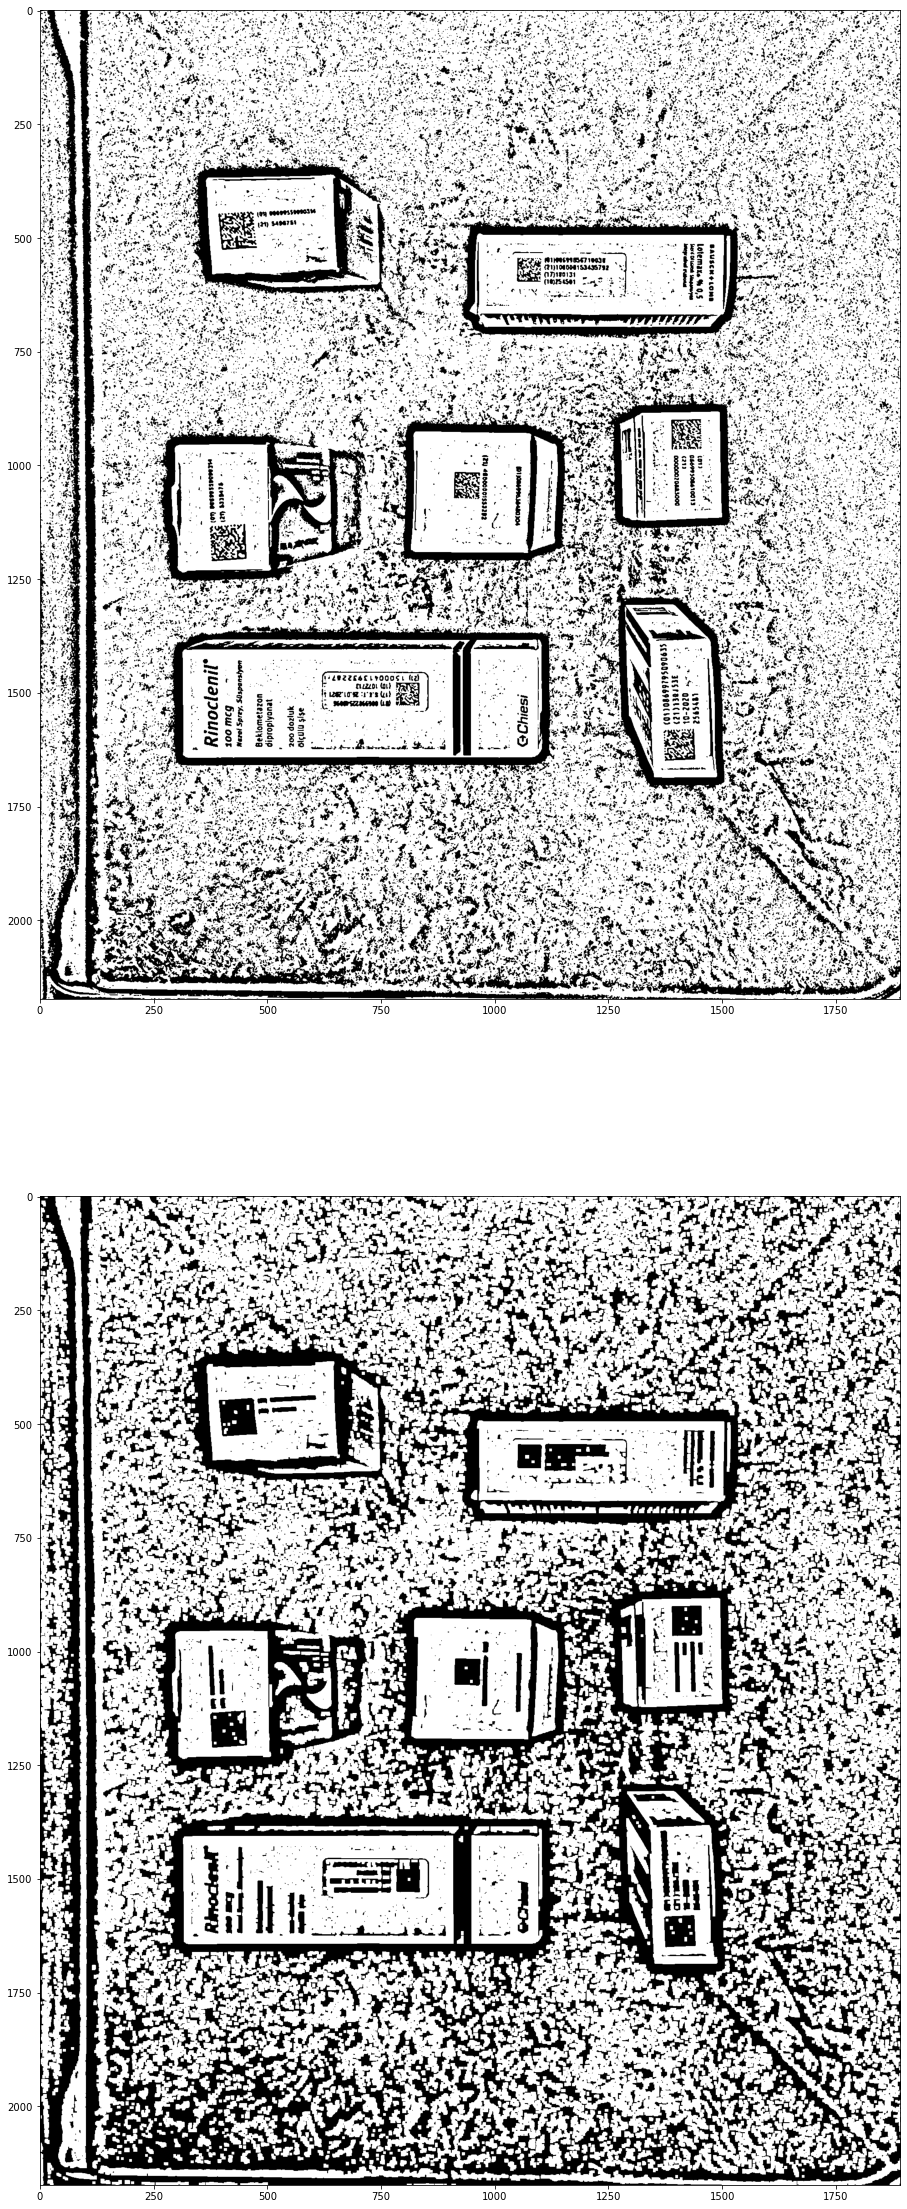

In [4]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(6,6))
opened = cv2.morphologyEx(adapt_mean, cv2.MORPH_OPEN, kernel)

plt.figure(figsize=(40,40))

plt.subplot(2,1,1)
plt.imshow(adapt_mean,'gray')

plt.subplot(2,1,2)
plt.imshow(opened,'gray')

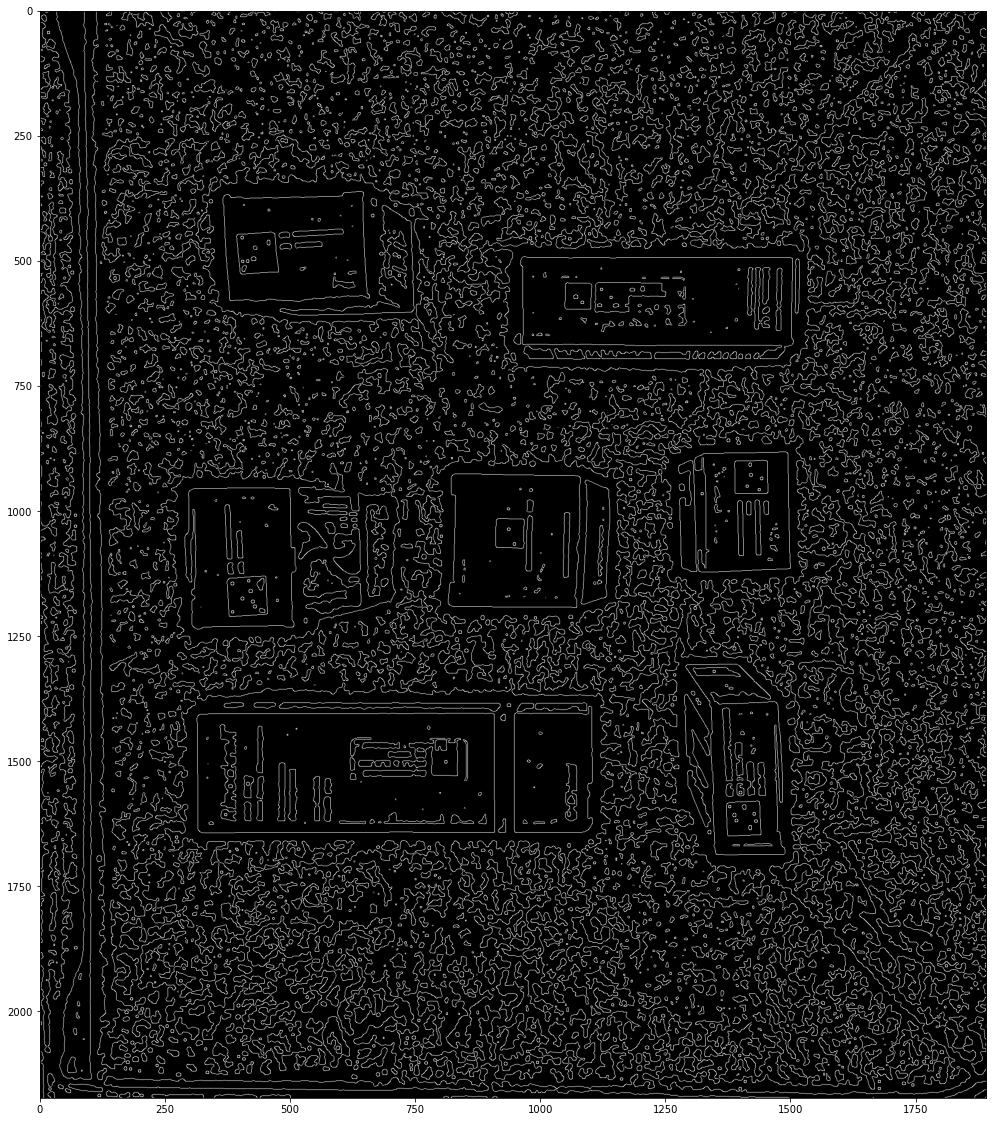

In [5]:
blurred_new = cv2.medianBlur(opened ,5) 


v = np.median(blurred_new)
sigma = 0.33

#---- Apply automatic Canny edge detection using the computed median----

lower = int(max(0, (1.0 - sigma) * v))
upper = int(min(255, (1.0 + sigma) * v))
edged = cv2.Canny(blurred_new, lower, upper)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(edged,cmap ='gray')


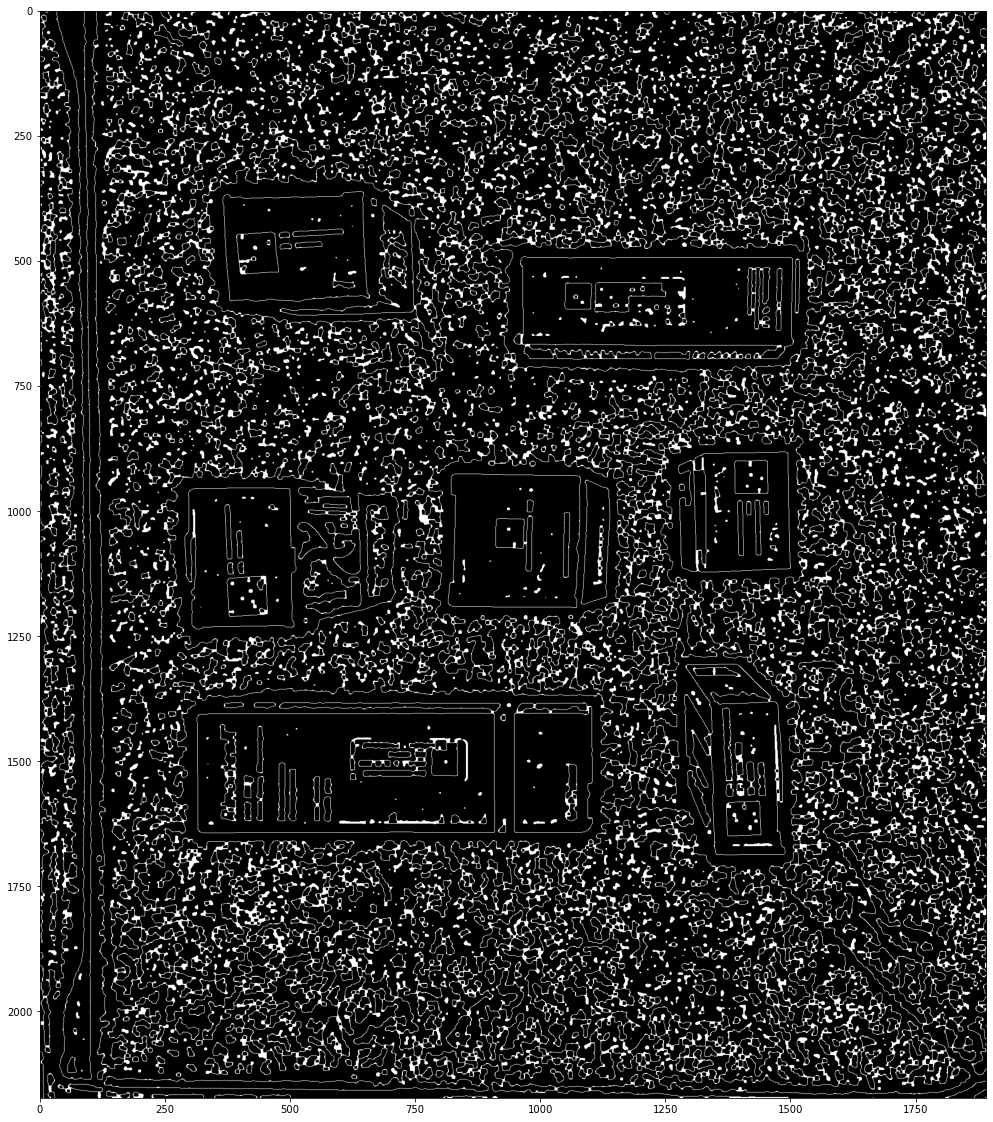

In [6]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (5, 5))
closed = cv2.morphologyEx(edged, cv2.MORPH_CLOSE, kernel)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(closed,cmap ='gray')

In [7]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

area_threshold = 50*50
aspect_ratio_threshold = 7
irregularity_threshold = 0.1
adjacency_threshold = 0.5

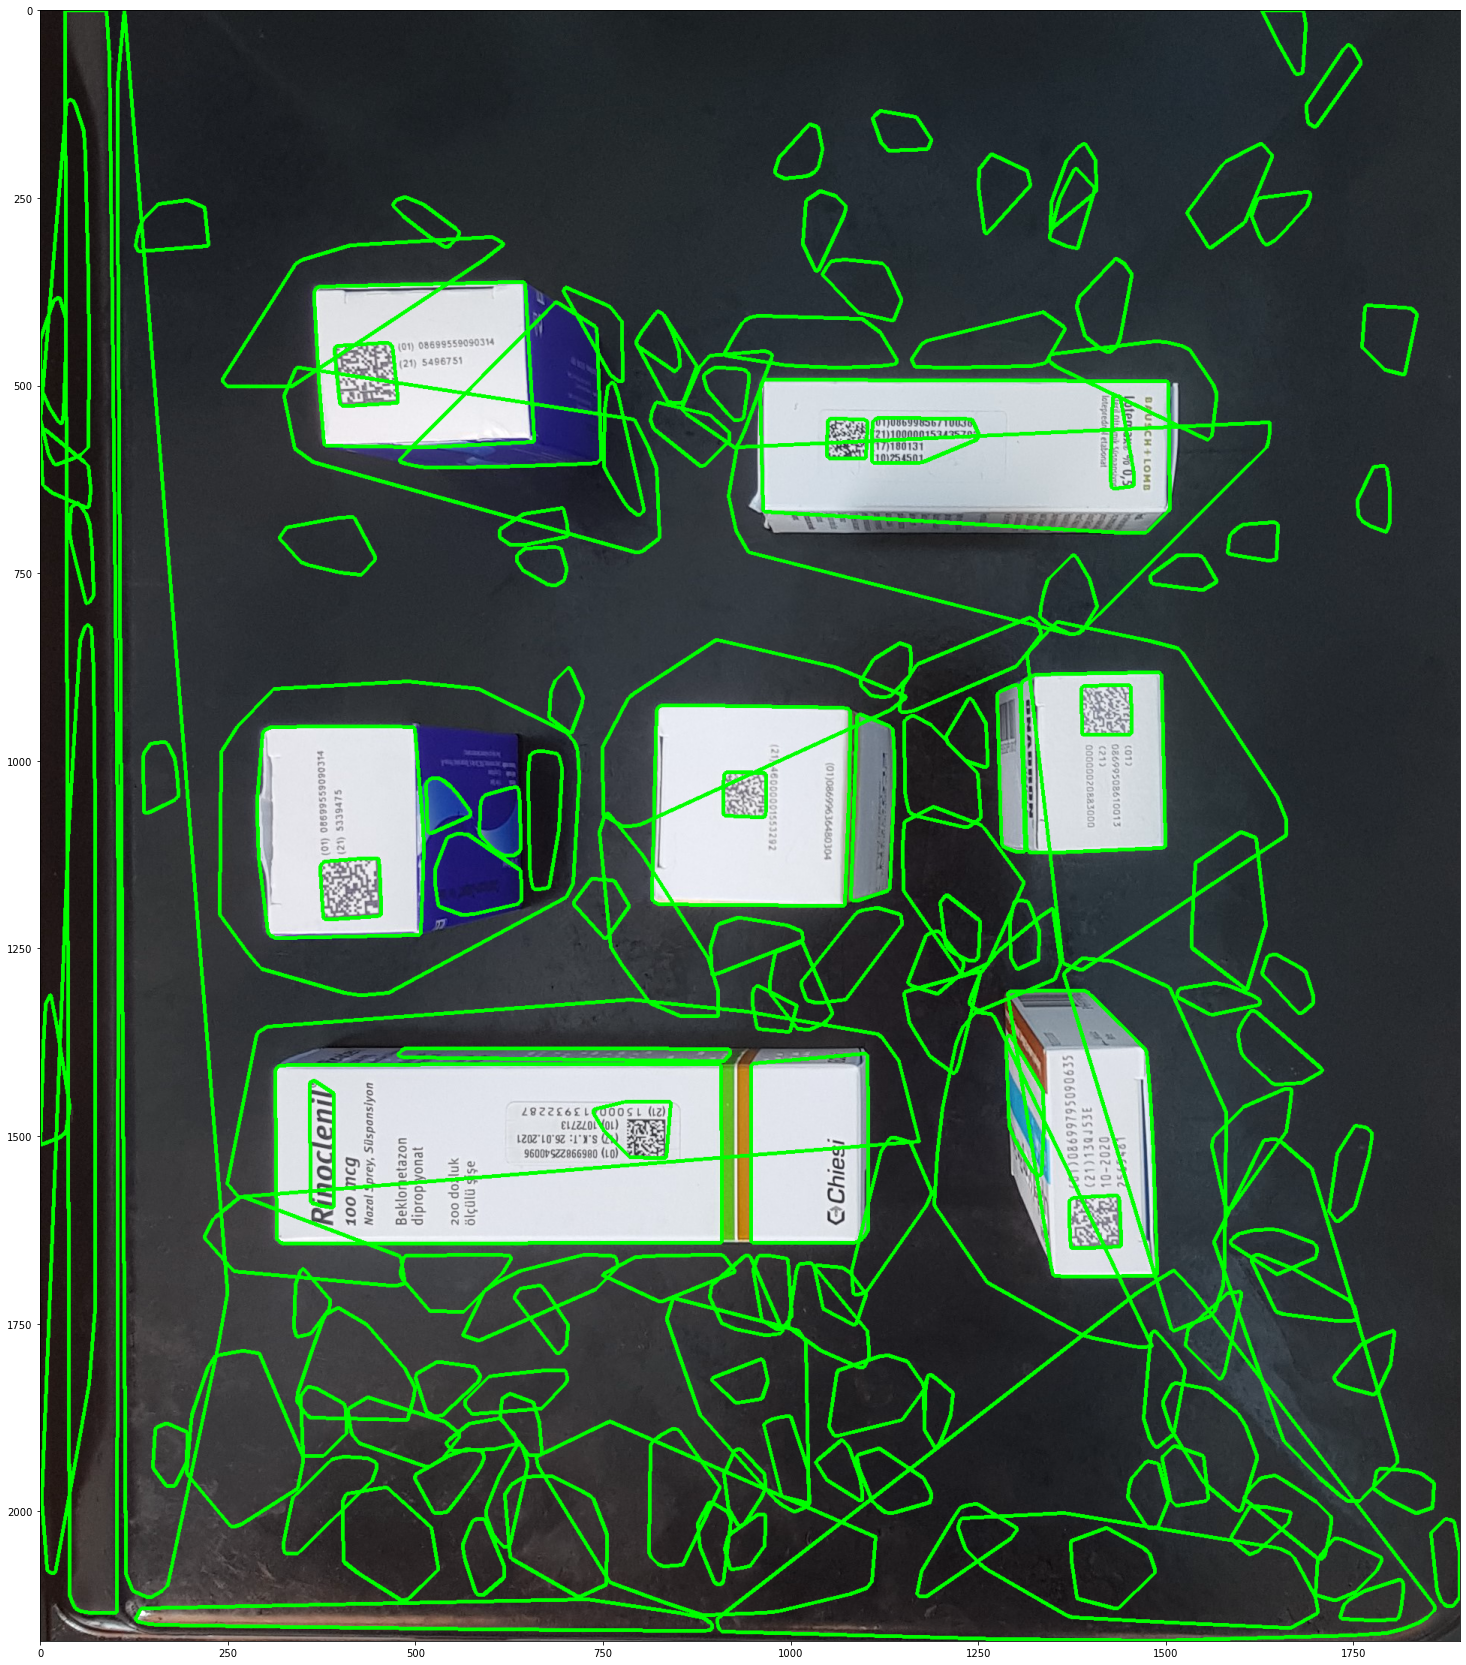

In [8]:
contours, hierarchy = cv2.findContours(edged, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cs = []
for i in range(len(contours)):
    approx = cv2.convexHull(contours[i])

    if cv2.contourArea(approx)>area_threshold :
            cs.append(approx) 


cntim = image_coloured.copy()
cntim = cv2.drawContours(cntim, cs, -1, (0,255,0), 3)

plt.figure(figsize=(30,30))

plt.imshow(cntim)

In [9]:
from shapely.geometry import Polygon,box

In [10]:
def removeDuplicates(boxes):
    i=0
    while i < len(boxes):
        poly1 = Polygon(boxes[i])
        j = i+1
        while j < len(boxes):
            poly2 = Polygon(boxes[j])
            if poly1.equals(poly2) or poly1.almost_equals(poly2, decimal=-1): del boxes[j]
                
            else: j += 1
        i +=1
    return boxes

0
0
1
1
1
1
1


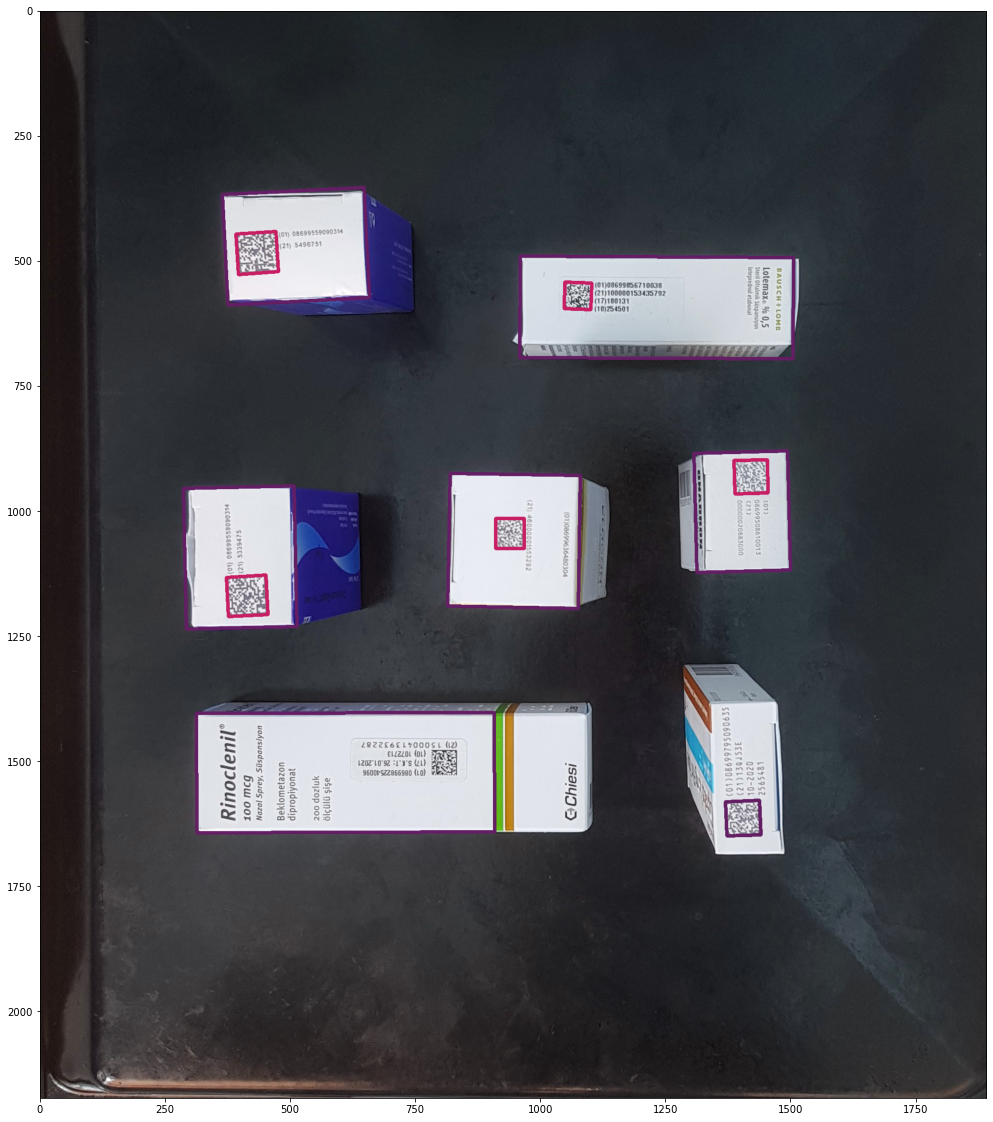

In [12]:
rects = []
boxes = []

for i in range(len(contours)):
    approx = cv2.convexHull(contours[i])
    
    #intersection = 0

    contArea = cv2.contourArea(approx)
    
    #AREA THRESHOLD
    if contArea > area_threshold :
        
        #IRREGULARITY (NON-RECTANGULARITY) MEASUREMENT
        irregularity = 0
        aspect_ratio = 0
    
        rect = cv2.minAreaRect(approx)
        (x1,y1),(w1,h1),_ = rect
        
        rectArea = w1*h1

        irregularity = abs(rectArea-contArea)/rectArea
        
        #ASPECT RATIO MEASUREMENT
        aspect_ratio = w1/h1
        
        
        if irregularity < irregularity_threshold and 1/aspect_ratio_threshold < aspect_ratio < aspect_ratio_threshold :
            
            #SHAPE INTERACTIONS----------------------------------------------------------------------------------- 
            
            addRect = True
            j = 0
            
            box = [cv2.boxPoints(rect),[]]
            box[0] = np.int0(box[0]) 
            boxPoly1 = Polygon(box[0])
            
            while j < len(rects):
                (x2,y2),(w2,h2),_ = rects[j]

                boxPoly2 = Polygon(boxes[j][0])
                
                #CHECK FOR DUPLICATES 
                if boxPoly1.almost_equals(boxPoly2, decimal=0) or boxPoly1.equals(boxPoly2) \
                or not boxPoly1.within(Polygon([(1,1),(1,image_h-2),(image_w-2,image_h-2),(image_w-2,1)])):
                    addRect = False
                    break
                #CHECK FOR SHAPES AT EDGES OF FRAME
                
                #FIND SHAPES CONTAINED IN SHAPES
                if boxPoly1.contains(boxPoly2):
                    print(rect,"CONTAINS",rects[j])
                    if 1.1 > w2/h2 > 0.9:
                        #print("SQUARE")
                        box[1].extend(boxes[j][1])
                        box[1].append(boxes[j][0])
                        
                        
                    else:
                        box[1].extend(boxes[j][1])
                        #print("NOT SQUARE: ",w2/h2)
                        #print("DELETER : ",rects[j])
                        #print("DELETED : ", rectArea,rectArea2)
                    del rects[j]
                    del boxes[j]
                        
                elif boxPoly1.within(boxPoly2):
                    addRect = False
                    #print(rects[j],"CONTAINS",rect)
                    if 1.1 > aspect_ratio > 0.9:
                        #print("SQUARE")
                        boxes[j][1].extend(box[1])
                        boxes[j][1].append(box[0])
                        j+=1 
                    else:
                        #print("NOT SQUARE: ",w1/h1)
                        boxes[j][1].extend(box[1])
                        #print("eliminated : ",rectArea,rectArea2, rect)
                        break
                
                #FIND SHAPES CROSSING, TOUCHING OR IN CLOSE PROXIMITY (DETERMINED BY THRESHOLD)
                elif boxPoly1.crosses(boxPoly2) \
                or boxPoly1.touches(boxPoly2) \
                or boxPoly1.distance(boxPoly2) < min(w1,h1,w2,h2)*adjacency_threshold :
                    #print("interacting shapes")
                    rectArea2 = w2*h2
                    #print("cross or touch: ",boxPoly1.crosses(boxPoly2),boxPoly1.touches(boxPoly2))
                    
                    #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                    #print("distance: ",boxPoly1.distance(boxPoly2))
                    
                    if rectArea <= rectArea2:
                        
                        addRect = False
                        
                        if 1.1 > aspect_ratio > 0.9:
                            #print("SQUARE")
                            boxes[j][1].extend(box[1])
                            boxes[j][1].append(box[0])
                            j+=1 
                        else:
                            #print("NOT SQUARE: ",w1/h1)
                            boxes[j][1].extend(box[1])
                            #print("eliminated : ",rectArea,rectArea2, rect)
                                            
                        #print("eliminated : ",rectArea,rectArea2, rect)
                        break
                    else:
                        #print("DELETER : ",rects[j], rectArea)
                        #print("DELETED : ",rectArea2)
                        if 1.1 > w2/h2 > 0.9:
                            #print("SQUARE")
                            box[1].extend(boxes[j][1])
                            box[1].append(boxes[j][0])
                        else:
                            box[1].extend(boxes[j][1])
                            #print("NOT SQUARE: ",w2/h2)
                            
                        del rects[j]
                        del boxes[j]
                else: 
                    #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                    j+=1
                        
                        
            if addRect:
                rects.append(rect)
                boxes.append(box)
                #print("RECT: ",rect)

rect_img = image_coloured.copy()


for i in range(len(boxes)):
    if len(boxes[i][1])>1:
        boxes[i][1] = removeDuplicates(boxes[i][1])
        
    cv2.drawContours(rect_img, [boxes[i][0]], -1, (100,30,100), 5) 
    cv2.drawContours(rect_img, boxes[i][1], -1, (200,30,100), 5) 
    print(len(boxes[i][1]))
    

plt.figure(figsize=(20,20))

plt.imshow(rect_img)



#cv2.imwrite('C:/Users/User/Desktop/barcode_proj/images/results/white_background3.jpg',contoured)




In [ ]:
from pylibdmtx.pylibdmtx import decode

In [ ]:
rect_img = image_coloured.copy()
font = cv2.FONT_HERSHEY_SIMPLEX
margin = 5


for box in boxes:
    result = []
    readible = False
    
    if not len(box[1]):
        cv2.drawContours(rect_img, [box[0]], -1, (255,99,71), 5)
        cv2.putText(rect_img,'No Barcode Found',(box[0][1][0],box[0][1][1]), font, 1, (255,99,71), 3, cv2.LINE_AA)
    else:
        #print(box[1])
        for matrixBox in box[1]:
            x,y,w,h = cv2.boundingRect(matrixBox)

            result = decode(  adapt_mean[ y-margin : y+h+margin,x-margin : x+w+margin ] )
            #CHECK IF MATRIX WAS DECODED
            if len(result):
                print("decoded: ", result[0].data)
                readible = True
                cv2.rectangle(rect_img,(x,y),(x+w,y+h),(50,205,50),4)
                cv2.putText(rect_img,'Decoding Succesfull',(x-margin,y-margin), font, 1, (50,170,50), 2, cv2.LINE_AA)
                cv2.putText(rect_img, str(result[0].data) ,(x-margin,y-margin*7), font, 1, (50,170,50), 2, cv2.LINE_AA)
            else:
                cv2.rectangle(rect_img,(x,y),(x+w,y+h),(255,215,0),4)
                
        
    if not readible: 
        cv2.drawContours(rect_img, [box[0]], -1, (255,70,0), 5) 
        cv2.putText(rect_img,'Decoding Failed',(box[0][1][0],box[0][1][1]), font, 1, (255,70,0), 3, cv2.LINE_AA)
    else:
        cv2.drawContours(rect_img, [box[0]], -1, (50,205,50), 5) 

#rect_img = cv2.drawContours(rect_img, outBoxes, -1, (100,30,100), 5) 


plt.figure(figsize=(20,20))

plt.imshow(rect_img)






In [ ]:
def isDuplicate(poly1,poly2):
    return poly1.almost_equals(poly2, decimal=1) or poly1.equals(poly2)

In [ ]:
rects = []
boxes = []
dataMatrice_candidates = []


for i in range(len(contours)):
    approx = cv2.convexHull(contours[i])
    
    #intersection = 0

    contArea = cv2.contourArea(approx)
    
    #AREA THRESHOLD
    if contArea > area_threshold :
        
        #IRREGULARITY (NON-RECTANGULARITY) MEASUREMENT
        irregularity = 0
        aspect_ratio = 0
    
        rect = cv2.minAreaRect(approx)
        (x1,y1),(w1,h1),_ = rect
        
        rectArea = w1*h1

        irregularity = abs(rectArea-contArea)/rectArea
        
        #ASPECT RATIO MEASUREMENT
        aspect_ratio = w1/h1
        
        
        if irregularity < irregularity_threshold and 1/aspect_ratio_threshold < aspect_ratio < aspect_ratio_threshold :
            
            #SHAPE INTERACTIONS----------------------------------------------------------------------------------- 
            
            addRect = True
            j = 0
            
            box = [cv2.boxPoints(rect),[],0]
            box[0] = np.int0(box[0]) 
            boxPoly1 = Polygon(box[0])
            
            while j < len(rects):
                (x2,y2),(w2,h2),_ = rects[j]

                boxPoly2 = Polygon(boxes[j][0])
                
                #CHECK FOR DUPLICATES 
                if isDuplicate(boxPoly1,boxPoly2) or box[2] \
                or not boxPoly1.within(Polygon([(1,1),(1,image_h-2),(image_w-2,image_h-2),(image_w-2,1)])):
                    addRect = False
                    break
                #CHECK FOR SHAPES AT EDGES OF FRAME
                
                #FIND SHAPES CONTAINED IN SHAPES
                if boxPoly1.contains(boxPoly2):
                    print(rect,"CONTAINS",rects[j])
                    if 1.1 > w2/h2 > 0.9:
                        box[1].append(boxes[j][0])
                        boxes[j][2]=1
                        j +=1
                        
                        
                    else:
                        del rects[j]
                        del boxes[j]
                        
                elif boxPoly1.within(boxPoly2) and not boxes[j][2]:

                    #print(rects[j],"CONTAINS",rect)
                    if 1.1 > aspect_ratio > 0.9:
                        for square in boxes[j][1]:
                            if isDuplicate(boxPoly1,Polygon(square)): 
                                addRect = False
                                break
                        if not addRect: break
                        boxes[j][1].append(box[0])
                        j+=1 
                    else:
                        addRect = False
                        break
                
                #FIND SHAPES CROSSING, TOUCHING OR IN CLOSE PROXIMITY (DETERMINED BY THRESHOLD)
                elif boxPoly1.crosses(boxPoly2) \
                or boxPoly1.touches(boxPoly2) \
                or boxPoly1.distance(boxPoly2) < min(w1,h1,w2,h2)*adjacency_threshold :
                    #print("interacting shapes")
                    rectArea2 = w2*h2
                    #print("cross or touch: ",boxPoly1.crosses(boxPoly2),boxPoly1.touches(boxPoly2))
                    
                    #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                    #print("distance: ",boxPoly1.distance(boxPoly2))
                    
                    if rectArea <= rectArea2 and not boxes[j][2]:
                        
                        
                        if 1.1 > aspect_ratio > 0.9:
                            #print("SQUARE")
                            for square in boxes[j][1]:
                                if isDuplicate(boxPoly1,Polygon(square)): 
                                    addRect = False
                                    break
                            if not addRect: break
                            
                            boxes[j][1].append(box[0])
                            box[2]=1
                            j+=1 
                        else:
                            addRect = False
                            break
                    else:
                        #print("DELETER : ",rects[j], rectArea)
                        #print("DELETED : ",rectArea2)
                        if 1.1 > w2/h2 > 0.9:
                            box[1].append(boxes[j][0])
                            boxes[j][2]=1
                        else:
                            del rects[j]
                            del boxes[j]
                else: 
                    #print("distance/min(w1,h1,w2,h2) : ",boxPoly1.distance(boxPoly2)/min(w1,h1,w2,h2))
                    j+=1
                        
                        
            if addRect:
                rects.append(rect)
                boxes.append(box)
                #print("RECT: ",rect)

rect_img = image_coloured.copy()


for box in boxes:
    if not box[2]:
        cv2.drawContours(rect_img, box[1], -1, (200,30,100), 5) 
        cv2.drawContours(rect_img, [box[0]], -1, (100,30,100), 5) 
        print(len(box[1]))
    

plt.figure(figsize=(20,20))

plt.imshow(rect_img)



#cv2.imwrite('C:/Users/User/Desktop/barcode_proj/images/results/white_background3.jpg',contoured)


